In [130]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ai-5000-tools-2023/all_ai_tool.csv


In [131]:
data = pd.read_csv("/kaggle/input/ai-5000-tools-2023/all_ai_tool.csv")

Data Fields:

- AI Tool Name: The name of the AI tool or software.
- Description: A brief description of the tool's features and capabilities.
- Free/Paid/Other: Indicates whether the tool is available for free, has a paid subscription model, or falls under another pricing category.
- Useable For: Describes the primary use cases or applications for which the AI tool is suitable.
- Charges: Specifies the cost or pricing structure associated with the tool (if applicable).
- Review: User-generated reviews and ratings to provide insights into the tool's performance and user satisfaction.
- Tool Link: URL or link to access the AI tool's official website or download page.
- Major Category: Categorizes the AI tools into broader domains or categories, such as natural language processing (NLP), computer vision, data analytics, and more.

In [132]:
data.head()

,AI Tool Name,Description,Free/Paid/Other,Useable For,Charges,Review,Tool Link,Major Category
0,Farm3D,Learning Articulated 3D Animals by Distilling ...,Free,/ experiments / 3D,NaN,NaN,https://farm3d.github.io/?utm_source=futureped...,other
1,Mailbutler Ai,"AI-powered Smart Assistant for Outlook, Gmail ...",Freemium,/ email assistant,$ 4.95/mo,1,https://www.mailbutler.io/smart-assistant/?utm...,text
2,Maverick,Send customers personalized videos at scale.,Paid,/ e-commerce / audio editing,$ 100/mo,NaN,https://www.trymaverick.com/?utm_source=future...,audio
3,0Xai,Stable Diffusion Prompt And Images Generator,Free,/ image generator / prompts,NaN,NaN,https://0xai.quest?utm_source=futurepedia&utm_...,image
4,10Web,AI-powered WordPress platform for automated we...,Freemium,/ low-code/no-code,NaN,NaN,https://10web.io/?utm_source=futurepedia&utm_m...,code


In [133]:
data.info()
df = data.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4969 entries, 0 to 4968
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   AI Tool Name     4969 non-null   object
 1   Description      4969 non-null   object
 2   Free/Paid/Other  4969 non-null   object
 3   Useable For      4969 non-null   object
 4   Charges          2534 non-null   object
 5   Review           1462 non-null   object
 6   Tool Link        4969 non-null   object
 7   Major Category   4969 non-null   object
dtypes: object(8)
memory usage: 310.7+ KB


In [134]:
df.columns = (
    df.columns
    .str.lower()
    .str.strip()
    .str.replace(" ", "_")
    .str.replace("/", "_")
)
df.head()

,ai_tool_name,description,free_paid_other,useable_for,charges,review,tool_link,major_category
0,Farm3D,Learning Articulated 3D Animals by Distilling ...,Free,/ experiments / 3D,NaN,NaN,https://farm3d.github.io/?utm_source=futureped...,other
1,Mailbutler Ai,"AI-powered Smart Assistant for Outlook, Gmail ...",Freemium,/ email assistant,$ 4.95/mo,1,https://www.mailbutler.io/smart-assistant/?utm...,text
2,Maverick,Send customers personalized videos at scale.,Paid,/ e-commerce / audio editing,$ 100/mo,NaN,https://www.trymaverick.com/?utm_source=future...,audio
3,0Xai,Stable Diffusion Prompt And Images Generator,Free,/ image generator / prompts,NaN,NaN,https://0xai.quest?utm_source=futurepedia&utm_...,image
4,10Web,AI-powered WordPress platform for automated we...,Freemium,/ low-code/no-code,NaN,NaN,https://10web.io/?utm_source=futurepedia&utm_m...,code


### Charges column has different pricing, like per month or per credit etc. splitting the columns for now

In [135]:
import re

df["charges_value"] = None
df["charges_unit"] = None

pattern = re.compile(r'([\d.]+)\s*([a-zA-Z/]+)')

for i, j in enumerate(df.charges.fillna('')):
    match = pattern.search(j)
    if match:
        df.loc[i, "charges_value"] = float(match.group(1))
        df.loc[i, "charges_unit"] = match.group(2)

df[["charges_value", "charges_unit"]].head()

,charges_value,charges_unit
0,None,None
1,4.95,/mo
2,100.0,/mo
3,None,None
4,None,None


In [136]:
set(df.free_paid_other)

{'Contact for Pricing',
 'Deals',
 'Free',
 'Free Trial',
 'Free | Freemium | Paid',
 'Free | Paid',
 'Free-Trial | Deals',
 'Free-Trial | Freemium',
 'Free-Trial | Paid',
 'FreeDeals',
 'FreeFreemium',
 'Freemium',
 'Freemium | Deals',
 'Freemium | Free',
 'Freemium | Free-Trial',
 'Freemium |Contact for Pricing',
 'Paid',
 'Paid | Deals',
 'Paid |Free-Trial'}

### Let's tidy this part a bit:
- If a tool is marked "Free" and has a non-zero price, it will be recategorized as "Freemium."
- If a tool is marked "Paid" but has no price listed, we may flag it for further investigation.
- Otherwise, we'll keep only the existing categories ("Free," "Freemium," "Paid").

In [137]:
df["charges_value"] = df["charges_value"].astype(float)

# 'charges_value' to 0 where the product is free and the value is NaN
df.loc[(df["free_paid_other"] == 'Free') & (df["charges_value"].isna()), "charges_value"] = 0

# only if it is "Free" with a zero price, set it to "Free"
df.loc[(df["free_paid_other"].str.contains('Free', na=False)) & (df["charges_value"] == 0), "free_paid_other"] = 'Free'

# if labeled as 'Free' but has a non-zero price, recategorize as 'Freemium'
df.loc[(df["free_paid_other"] == 'Free') & (df["charges_value"] > 0), "free_paid_other"] = 'Freemium'

# any combination involving "Free" or "Freemium" will be labeled as "Freemium"
freemium_keywords = ['Free', 'Freemium']
df.loc[df["free_paid_other"].str.contains('|'.join(freemium_keywords), na=False) & (df["free_paid_other"] != 'Free'), "free_paid_other"] = 'Freemium'

# if labeled as 'Paid' or any combination involving 'Paid', set it to 'Paid'
paid_keywords = ['Paid', 'Contact for Pricing', 'Deals']
df.loc[df["free_paid_other"].str.contains('|'.join(paid_keywords), na=False), "free_paid_other"] = 'Paid'


In [138]:
set(df.free_paid_other)

{'Free', 'Freemium', 'Paid'}

In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4969 entries, 0 to 4968
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ai_tool_name     4969 non-null   object 
 1   description      4969 non-null   object 
 2   free_paid_other  4969 non-null   object 
 3   useable_for      4969 non-null   object 
 4   charges          2534 non-null   object 
 5   review           1462 non-null   object 
 6   tool_link        4969 non-null   object 
 7   major_category   4969 non-null   object 
 8   charges_value    3556 non-null   float64
 9   charges_unit     1867 non-null   object 
dtypes: float64(1), object(9)
memory usage: 388.3+ KB


In [140]:
df["free_paid_other"] = df["free_paid_other"].astype('category')
df["major_category"] = df["major_category"].astype('category')

df.dtypes

ai_tool_name         object
description          object
free_paid_other    category
useable_for          object
charges              object
review               object
tool_link            object
major_category     category
charges_value       float64
charges_unit         object
dtype: object

In [141]:
set(df.major_category)

{'3D', 'audio', 'business', 'code', 'image', 'other', 'text', 'video'}

In [142]:
# df['review'].fillna('Not Reviewed', inplace=True)

# -1 means not reviewed, better keep it numerical
df["review"].replace('undefined', -1, inplace=True)
df["review"].fillna(-1, inplace=True)

In [143]:
df["review"] = df["review"].astype(float)

In [144]:
df[df.review > 0].review.describe()

count    1459.000000
mean        1.916381
std         2.171615
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        42.000000
Name: review, dtype: float64

In [145]:
df[df.review > 10].review.describe()

count    13.000000
mean     15.846154
std       8.384968
min      11.000000
25%      11.000000
50%      14.000000
75%      15.000000
max      42.000000
Name: review, dtype: float64

In [146]:
# will replace the values above 10 for now with -1 (not reviewed)
df.loc[df.review > 10, "review"] = -1

In [147]:
df["review"] = df["review"].astype(float)

In [148]:
df.isna().sum()

ai_tool_name          0
description           0
free_paid_other       0
useable_for           0
charges            2435
review                0
tool_link             0
major_category        0
charges_value      1413
charges_unit       3102
dtype: int64

### Time for plotting

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns

### Considering there are differences on pricing per month, per year or with credits etc. will go back 'charge_value' later.

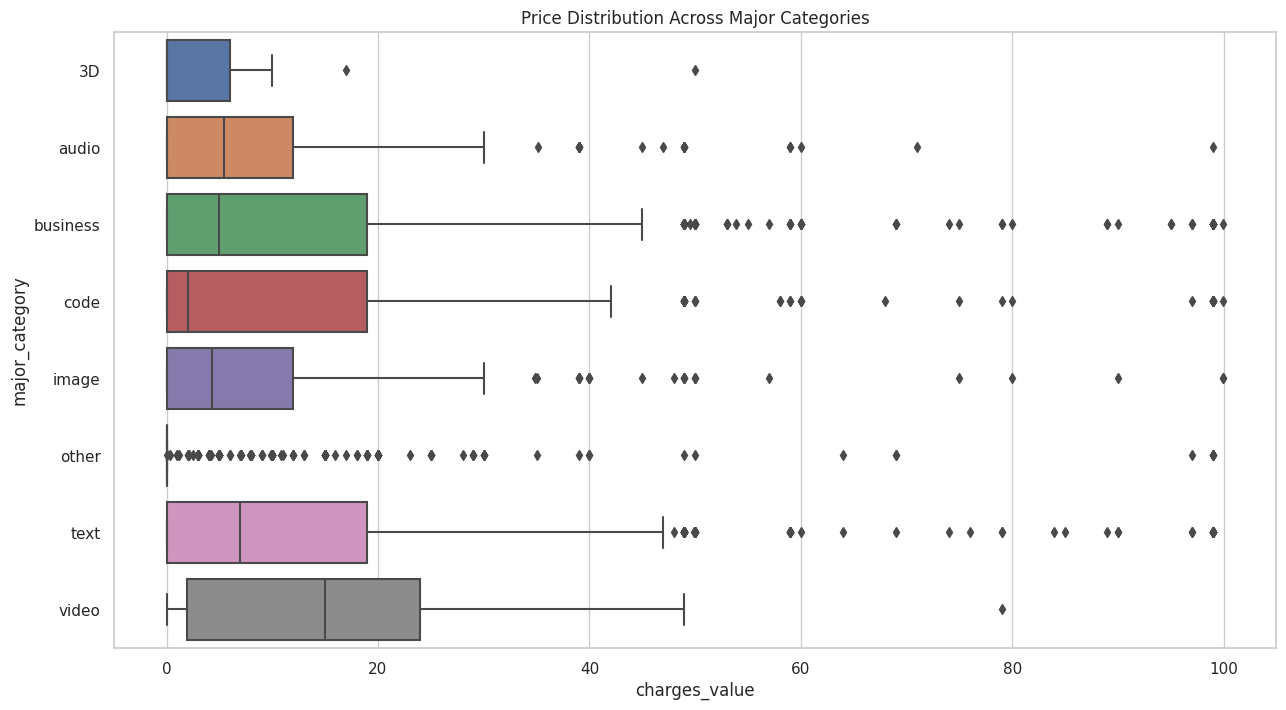

In [150]:
plt.figure(figsize=(15, 8))

# just to get a visual for prices under $100 for now
sns.boxplot(x='charges_value', y='major_category', data=df[df.charges_value<100])
plt.title('Price Distribution Across Major Categories')
plt.show()

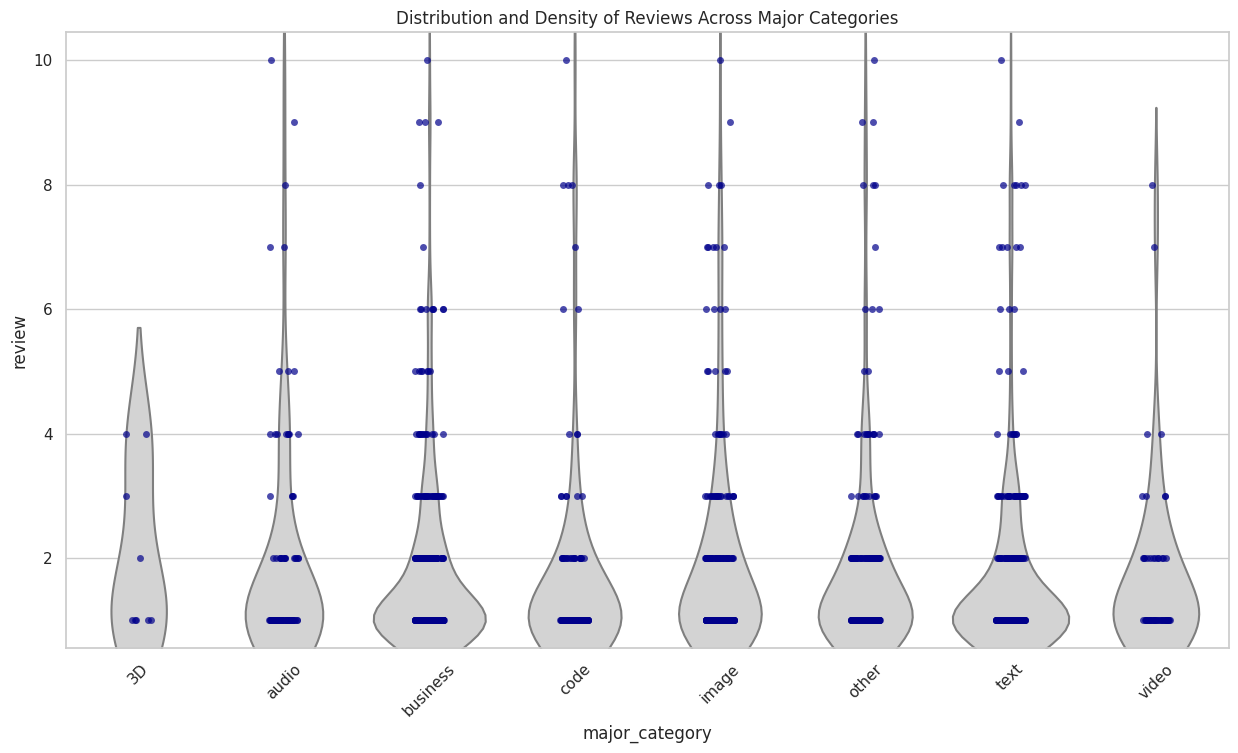

In [151]:
# filtering out no reviews
filtered = df[df["review"] > 0]

plt.figure(figsize=(15, 8))

sns.violinplot(x='major_category', y='review', data=filtered, inner=None, color='lightgrey')
sns.stripplot(x='major_category', y='review', data=filtered, jitter=True, alpha=0.7, color="darkblue")

plt.title('Distribution and Density of Reviews Across Major Categories')
plt.xticks(rotation=45)
plt.show()


In [152]:
grouped_reviews = df[df.review >= 0].groupby("free_paid_other")["review"].mean()
print(grouped_reviews)

free_paid_other
Free        1.882825
Freemium    1.853535
Paid        1.379913
Name: review, dtype: float64


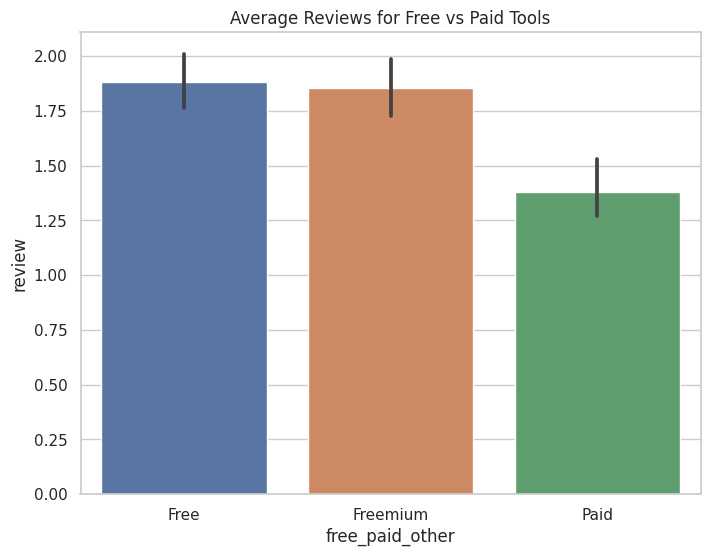

In [153]:
plt.figure(figsize=(8, 6))
sns.barplot(x='free_paid_other', y='review', data=df[df.review >= 0])
plt.title('Average Reviews for Free vs Paid Tools')
plt.show()

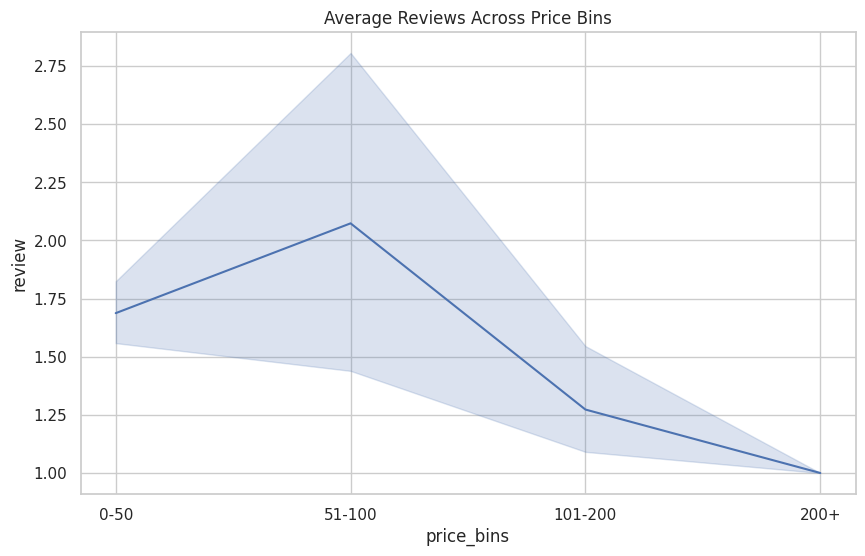

In [154]:
df["price_bins"] = pd.cut(df["charges_value"], bins=[0, 50, 100, 200, np.inf], labels=['0-50', '51-100', '101-200', '200+'])

plt.figure(figsize=(10, 6))
sns.lineplot(x="price_bins", y="review", data=df[df.review >= 0])
plt.title('Average Reviews Across Price Bins')
plt.show()


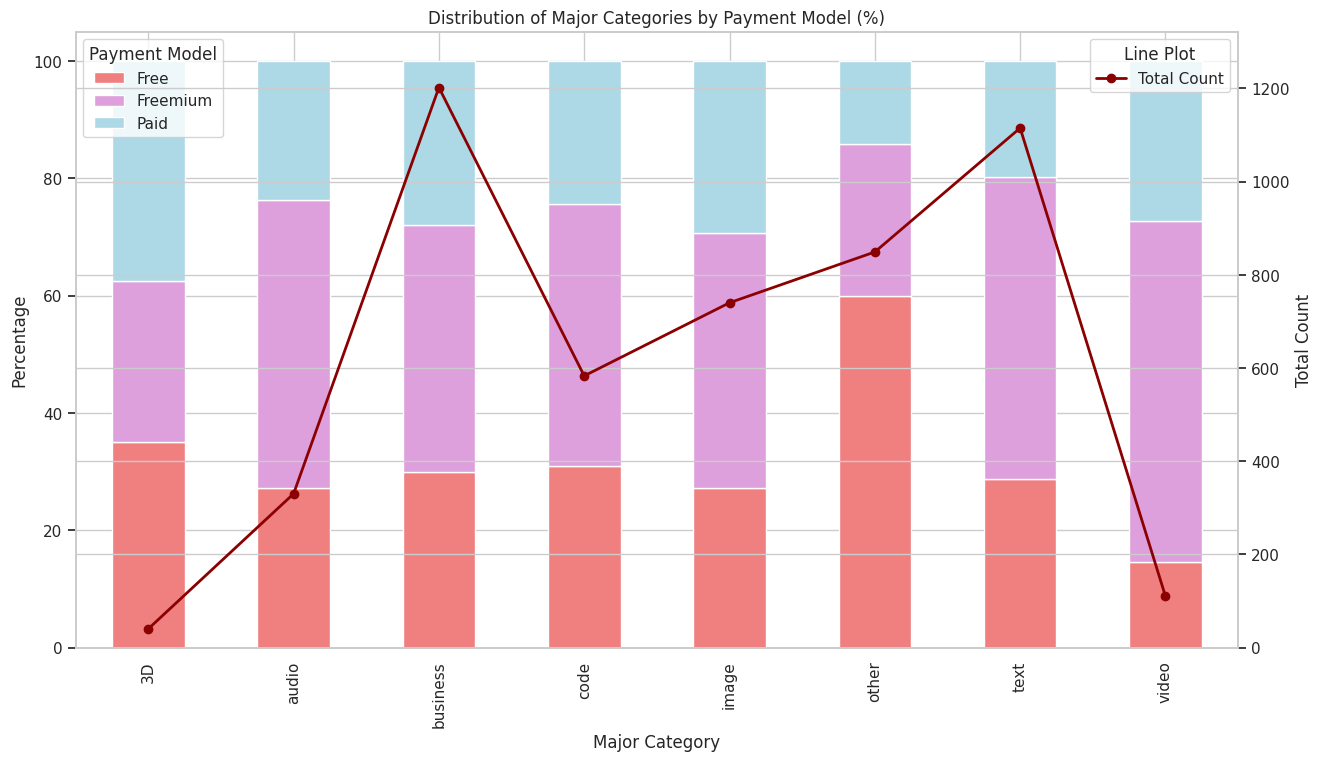

In [155]:
sns.set(style="whitegrid")
colors = ['lightcoral', 'plum', 'lightblue']

grouped_data = df.groupby(["major_category", "free_paid_other"]).size().reset_index(name='Count')
pivot_data = grouped_data.pivot(index="major_category", columns="free_paid_other", values='Count').fillna(0)

# normalizing for 100% view
pivot_data["Total"] = pivot_data.sum(axis=1)
for col in pivot_data.columns.difference(["Total"]):
    pivot_data[col] = (pivot_data[col] / pivot_data["Total"]) * 100


fig, ax1 = plt.subplots(figsize=(15, 8))
pivot_data.drop(columns=["Total"]).plot(kind='bar', stacked=True, ax=ax1, color=colors)
ax1.set_title('Distribution of Major Categories by Payment Model (%)')
ax1.set_ylabel('Percentage')
ax1.set_xlabel('Major Category')
ax1.legend(title='Payment Model', loc='upper left')


ax2 = ax1.twinx()
ax2.plot(ax1.get_xticks(), pivot_data["Total"].values, marker='o', linestyle='-', linewidth=2, color='darkred', label='Total Count')
ax2.legend(title='Line Plot', loc='upper right')
ax2.set_ylabel('Total Count')
ax2.set_ylim([0, max(pivot_data["Total"].values) * 1.1])  # extending upper limit for better visibility

plt.show()

In [156]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd  

class DataFilter:
    def __init__(self, df, filter_cols, sort_cols):
        self.df = df
        self.filter_cols = filter_cols
        self.sort_cols = sort_cols
        self.initialize_widgets()
        self.bind_events()
        self.display_widgets()
        self.filter_and_display_data(None)
        
    def initialize_widgets(self):
        self.dropdowns = {}
        
        for col, label in self.filter_cols.items():
            self.dropdowns[col] = widgets.Dropdown(
                options=['All'] + list(self.df[col].unique()),
                description=label
            )
        
        self.sort_by_dropdown = widgets.Dropdown(
            options=['None'] + self.sort_cols,
            description='Sort By:'
        )
        
        self.sort_order_dropdown = widgets.Dropdown(
            options=['None', 'Ascending', 'Descending'],
            description='Order:'
        )
        
        self.output = widgets.Output()
        
    def bind_events(self):
        for dropdown in self.dropdowns.values():
            dropdown.observe(self.filter_and_display_data, names='value')
        
        self.sort_by_dropdown.observe(self.filter_and_display_data, names='value')
        self.sort_order_dropdown.observe(self.filter_and_display_data, names='value')
    
    def display_widgets(self):
        for dropdown in self.dropdowns.values():
            display(dropdown)
        
        display(self.sort_by_dropdown)
        display(self.sort_order_dropdown)
        display(self.output)
        
    def filter_and_display_data(self, change):
        with self.output:
            clear_output()
            
            filtered_df = self.df.copy()
            
            for col, dropdown in self.dropdowns.items():
                if dropdown.value != 'All':
                    filtered_df = filtered_df[filtered_df[col] == dropdown.value]
            
            if self.sort_by_dropdown.value != 'None':
                ascending = True if self.sort_order_dropdown.value == 'Ascending' else False
                filtered_df = filtered_df.sort_values(by=self.sort_by_dropdown.value, ascending=ascending)
            
            display(filtered_df)

In [157]:
filter_cols = {"free_paid_other": "Free/Paid","major_category": "Category"}
sort_cols = ["review", "charges_value"]

data_filter = DataFilter(df, filter_cols, sort_cols)

Dropdown(description='Free/Paid', options=('All', 'Free', 'Freemium', 'Paid'), value='All')

Dropdown(description='Category', options=('All', 'other', 'text', 'audio', 'image', 'code', '3D', 'business', …

Dropdown(description='Sort By:', options=('None', 'review', 'charges_value'), value='None')

Dropdown(description='Order:', options=('None', 'Ascending', 'Descending'), value='None')

Output()